Importing libraries and modules

In [1]:
import physics
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


Reading Standard calibration media extended

In [2]:
# reading the data form the excel file
df = pd.read_excel('../Standard calibration in culture media_extended.xlsx', sheet_name='Raw data', )
df.head()

,E0_Blank_culture media MH - moving average baseline,Unnamed: 1,Pyo 100 uM_MH - moving average baseline,Unnamed: 3,Unnamed: 4,Pyo 50 uM_MH - moving average baseline,Unnamed: 6,Unnamed: 7,Pyo 25 uM_MH - moving average baseline,Unnamed: 9,...,Unnamed: 32,Unnamed: 33,Pyo 0.25 uM_MH - moving average baseline,Unnamed: 35,Unnamed: 36,Pyo 0.1 uM_MH - moving average baseline,Unnamed: 38,Unnamed: 39,Unnamed: 40,Unnamed: 41
0,V,µA,µA,µA,µA,µA,µA,µA,µA,µA,...,µA,µA,µA,µA,µA,µA,µA,µA,µA,µA
1,-0.600097,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,-0.595262,0.063593,0.098656,0.109374,0.115718,0.082966,0.110628,0.104234,0.088812,0.082304,...,0.079479,0.075286,0.075833,0.076125,0.079187,0.083927,0.078385,0.110979,0.051843,0.066755
3,-0.590427,0.054031,0.121318,0.130725,0.148006,0.099352,0.122679,0.113728,0.090737,0.073225,...,0.04127,0.070401,0.071166,0.054775,0.054862,0.065697,0.060739,0.079771,0.044581,0.064057
4,-0.585592,0.033967,0.136981,0.152074,0.173293,0.115738,0.113729,0.119721,0.085662,0.085147,...,0.038062,0.048015,0.045499,0.040424,0.044536,0.043967,0.064092,0.062562,0.030319,0.047358


### Dataset structure
- There are 42 signals, stored as column vectors
- The first signal, from the first column, represents the potential - denoted with $E$ and measured in $V$ (volts) - and this potential was applied in all experiments, ensuring the same potential window.
- The other signals represent the cureents - denoted with $I$ and measured in $\mu A$ (microampers) - characteristic to the initial potential $E$ and to the concentration values - denoted with $c$ and measured in $\mu M$ (micromolars), for which the experiment was performed.
- For each concentration were performed a number of readings, as shown bellow:

| $c$ [$\mu M$]| Number of readings |
| -------- | ------- |
| 0 | 1 (the blank signal)|
| 100 | 3 |
| 50 | 3 |
| 25 | 3 |
| 15 | 3 |
| 10 | 3 |
| 7.5 | 3 |
| 5 | 3 |
| 2.5 | 2 |
| 1 | 3 |
| 0.5 | 6 |
| 0.5 | 6 |
| 0.25 | 3 |
| 0.1 | 5 |

### The Problem we are trying to solve
- Create a ML model that predicts the concentration value (in $\mu M$) of a given voltammogram signal.
- The current signal, represented in the voltammogram, can be seen as a function of potential. Therefore, the entire problem can be written as:
$$c = I(E)$$

In [3]:
# extracting potential and current values
concentrations = [
    0,
    100,
    100,
    100,
    50,
    50,
    50,
    25,
    25,
    25,
    15,
    15,
    15,
    10,
    10,
    10,
    7.5,
    7.5,
    7.5,
    5,
    5,
    5,
    2.5,
    2.5,
    1,
    1,
    1,
    0.5,
    0.5,
    0.5,
    0.5,
    0.5,
    0.5,
    0.25,
    0.25,
    0.25,
    0.1,
    0.1,
    0.1,
    0.1,
    0.1
]
# the same potential was applied to each experiment
potential: np.ndarray = df.iloc[1:, 0].values.astype(float)

# the next columns represent the currents for each experiment
# they will be stored inside a list
currents: list[np.ndarray] = []
for col in df.columns[1:]:
    currents.append(df[col].values[1:].astype(float))


plotting each voltammogram

In [4]:
# This is not necessary to run every time, only when you want to save the plots

# path = 'voltammograms'
# if not os.path.exists(path):
#     os.makedirs(path)

# for i, current in enumerate(currents):
#     peak = max(current[18:70])
#     peak_voltage = potential[list(current).index(peak)]
# # create a new figure for each plot and close it after saving
#     plt.figure(figsize=(6, 4))
#     plt.plot(potential, current)
#     plt.plot(peak_voltage, peak, 'rx')
#     plt.grid()
#     plt.xlabel('Voltage (V)')
#     plt.ylabel('Current (µA)')
#     plt.title(f'Voltammogram {i},\nConcentration: {concentrations[i]} µM,\npeak at {round(peak, 2)} µA and {round(peak_voltage, 2)} V')
#     fname = f'voltammograms/voltammogram_{i:02d}.jpg'
#     plt.savefig(fname, bbox_inches='tight', dpi=200)
#     # plt.show()
#     plt.close()


# Pre-processing the signals

### Extracting the base noise from eachh signal
The second column, represents the currents registered when no drop of pyocyanin was present. This signal needs to be substracted form the rest of the currents to standarsize all the signals.

In [5]:
base_signal = currents[0]
normalized_currents: list[np.ndarray] = []

for current in currents:
    normalized_current = current - base_signal
    normalized_currents.append(normalized_current)

# for i, normalized_current in enumerate(normalized_currents):
#     peak = max(normalized_current[18:70])
#     peak_voltage = potential[list(normalized_current).index(peak)]
#     plt.figure(figsize=(6, 4))
#     plt.plot(potential, normalized_current)
#     plt.plot(peak_voltage, peak, 'rx')
#     plt.grid()
#     plt.xlabel('Voltage (V)')
#     plt.ylabel('Normalized Current (µA)')
#     plt.title(f'Normalized Voltammogram {i},\nConcentration: {concentrations[i]} µM,\npeak at {round(peak, 2)} µA and {round(peak_voltage, 2)} V')
#     fname = f'voltammograms/normalized_voltammogram_{i:02d}.jpg'
#     plt.savefig(fname, bbox_inches='tight', dpi=200)
#     # plt.show()
#     plt.close()

Smoothing the signal using Savitzky-Golay algorithm.

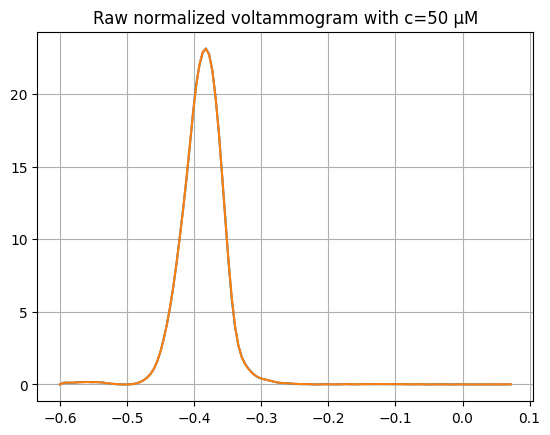

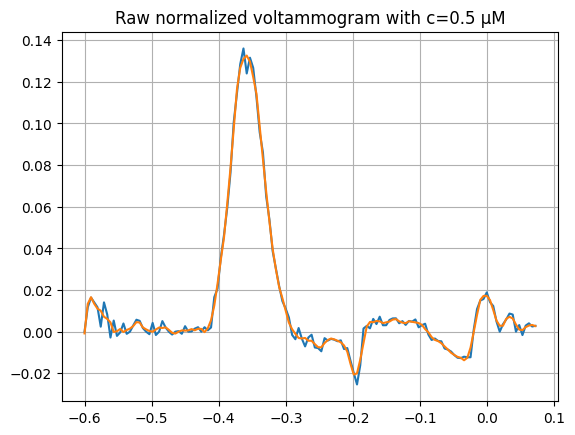

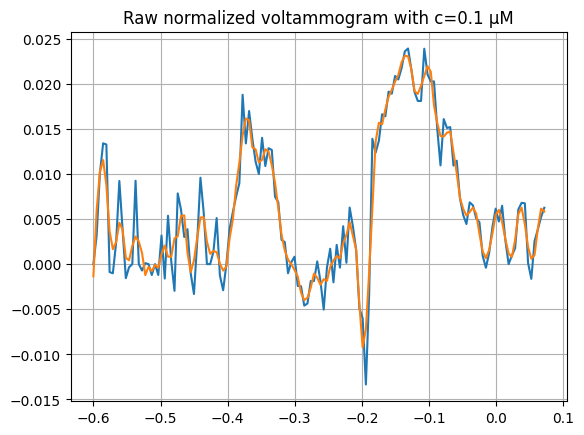

In [6]:
from scipy.signal import savgol_filter

window_length = 7
polyorder = 3

# taking 3 test signals from different concentrations
# c = 50 µM
test_current = currents[5][:140]
smoothed_current = savgol_filter(test_current, window_length=window_length, polyorder=polyorder)
plt.plot(potential[:140], test_current)
plt.plot(potential[:140], smoothed_current[:140])
plt.title(f'Raw normalized voltammogram with c={concentrations[5]} µM')
plt.grid()
plt.show()

# c = 0.5 µM
test_current = normalized_currents[32][:140]
smoothed_current = savgol_filter(test_current, window_length=window_length, polyorder=polyorder)
plt.plot(potential[:140], test_current)
plt.plot(potential[:140], smoothed_current[:140])
plt.title(f'Raw normalized voltammogram with c={concentrations[32]} µM')
plt.grid()
plt.show()

# c = 0.1 µM
test_current = normalized_currents[40][:140]
smoothed_current = savgol_filter(test_current, window_length=window_length, polyorder=polyorder)
plt.plot(potential[:140], test_current)
plt.plot(potential[:140], smoothed_current[:140])
plt.title(f'Raw normalized voltammogram with c={concentrations[40]} µM')
plt.grid()
plt.show()


# Feature extraction
---
### Category A: Electrochemical Features
- the highest importance

| *   | Feature                   | Details | Reference |
| --- | ------------------------- | ----- | --------- |
| 1.  | Peak current ($I_p$)      | The peak represents the amount of electroactive species being oxidized or reduced. | Laviron, J. Electroanal. Chem. (1979) & Nicholson, Anal. Chem. (1965) |
| 2.  | Peak potential ($E_p$)    | The potential corresponding for that peak current. It represents the redox potential of pyocyanin under your experimental conditions. |
| 3.  | Raw AUC | Raw peak area under the curve. This represents the total charge transferred during the redox event. $$AUC_{raw}=\int I(E) dE$$|
| 4.  | baseline-corrected AUC | $$AUC_{corrected}=\int (I(E) - I_{baseline}(E)) dE$$ | Bard & Faulkner, Electrochemical Methods, Ch. 6 |
| 5.  | Full width at half maximum (FWHM) | Indicates how sharp or broad the peak is. Peak broadening often increases at low concentration, noisy regimes and surface effects. |
| 6.  | Peak full width at 10% of height | ... |
| 7.  | Peak full width at 90% of height | ... |
| 8.  | Peak prominence                | Height of the peak relative to its surrounding baseline, not absolute zero. $$I_{p}-max(min_{L},min_{R})$$| SciPy signal processing docs; Massart et al., Chemometrics |
| 9.  | Peak height / peak area ratio                | Use baseline-corrected peak area. Raw AUC would contaminate the ratio with baseline, while the corrected AUC reflects true change. $$\frac{I_{p}}{AUC_{corrected}}$$| ... |
| 10.  | First derivative at peak | At an ideal maximum it would be zero. It will act as a wuality indicator. $$\frac{dI}{dk}=\frac{I[k+1]-I[k-1]}{2\Delta E}$$ | Savitzky & Golay, Analytical Chemistry (1964) |
| 11.  | Second derivative at peak                | Peak sharpness, i.e. the second derrivative at the peak. Second derivative tells you how tight the maximum is. $$\frac{d^{2}I}{dk^{2}}=\frac{I[k+1]-2I[k]+I[k-1]}{\Delta E^{2}} $$ | Savitzky & Golay, Analytical Chemistry (1964) |
| 12.  | Third derivative at peak                | Third derivative measures asymmetry of curvature change: how asymmetrically sharp. It detects subtle kinetic asymmetries. (Exploratory feature only). $$\frac{d^{3}I}{dk^{3}}=\frac{I[k+2]-2I[k+1]+2I[k-1]-I[k-2]}{2\Delta E^{3}} $$ | Savitzky & Golay, Analytical Chemistry (1964) |
| 13.  | Peak current / FWHM | The ratio between peak current and the full width at half maximum: $$ \frac{I_{p}}{FWHM} $$ | ... |
| 14.  | AUC / FWHM | The ratio between the baseline corrected peak area under the curve and the full width at half maximum: $$ \frac{AUC_{corrected}}{FWHM} $$ | ... |
| 15.  | mean current in $ \pm\Delta E $ | The average signal level around the peak. A fixed, small voltage window centered at $E_{p}$: $$\mu_{local}=\frac{1}{\|W\|}\sum_{i \in W}I_{i}$$ where $$W=\{i\|k_{p}-m\leq i \leq k_{p}+m \}$$ and $m\in[2,5]$ usually. | ... |
| 16.  | Standard deviation of current centered at $E_{p}$ | Local fluctuation near peak $E_{p}$: $$\sigma_{local}=\sqrt{\frac{1}{\|W\|}\sum_{i \in W}(I_{i}-\mu_{local})^{2}}$$ where $$W=\{i\|k_{p}-m\leq i \leq k_{p}+m \}$$ and $m\in[2,5]$ usually. | ... |
| 17.  | Local baseline offset at $E_{p}$ | ... | ... |

| 6.  | Right slope               | The first derivative of the descending flank of the signal. This can indicate how fast the electrochemical reaction turns off. |
| 7.  | The slope asymetry        | The ratio of left slope to right slope. his can indicate if the peak is symmetric or skewed. |
| 8.  | The mean slope            | The mean of the left and the right slope. This can describe the overall steepness. |        
| 9.  | Peak sharpness            | The second derivative computed at the peak value. It describes how tight the peak is. |
| 10.  | Signal to noise ration (SNR) | Essential for low concentrations. Noise is estimated from a region without active signal. This will describe the amount of noise in the signal, leting to an indicative for low concentrations. |



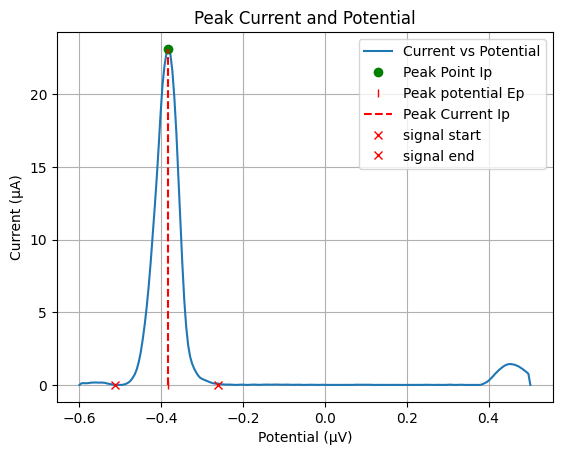

Peak current: 23.124492267985282 µA
Peak potential: -0.382515 V
Peak index: 45


In [7]:
Ip, Ep, peak_idx = physics.get_peak_values(potential, currents[5], plotting=True)
print(f'Peak current: {Ip} µA')
print(f'Peak potential: {Ep} V')
print(f'Peak index: {peak_idx}')

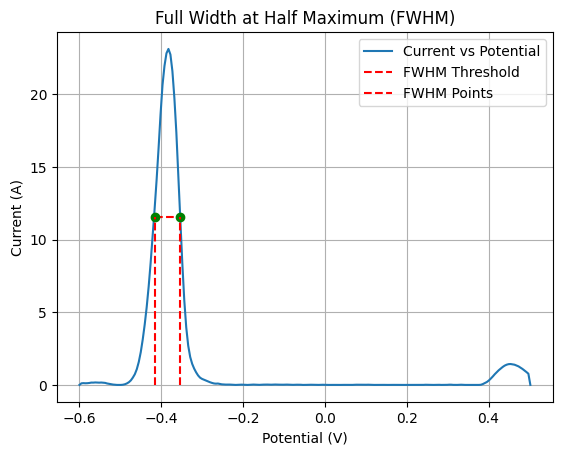

Full Width at Half Maximum: 0.062857 V


In [8]:
FWHM = physics.get_peak_FWHM(potential, currents[5], plotting=True)
print(f'Full Width at Half Maximum: {FWHM} V')

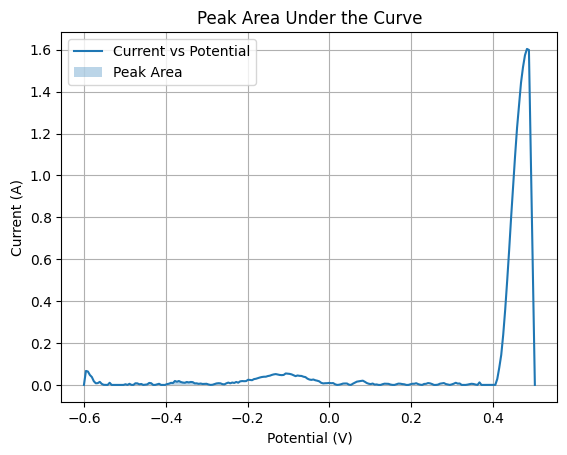

Area Under the Curve: 0.0014479735123441278 µA·V


In [ ]:
AUC = physics.get_peak_area(potential, currents[5], plotting=True)
print(f'Area Under the Curve: {AUC} µA·V')

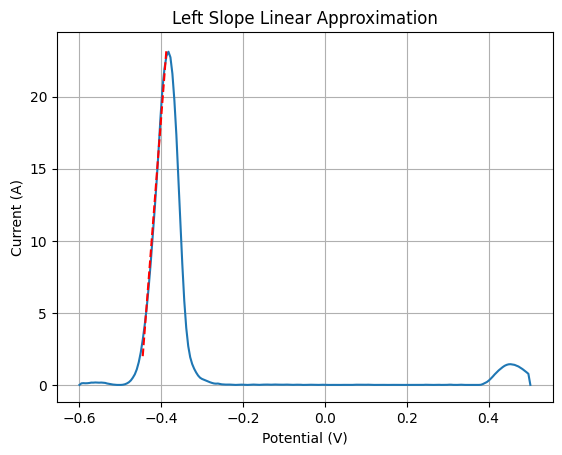

Left slope: 367.5004828586509 µA/V


In [10]:
left_slope = physics.get_left_slope(potential, currents[5], plotting=True)
print(f'Left slope: {left_slope} µA/V')

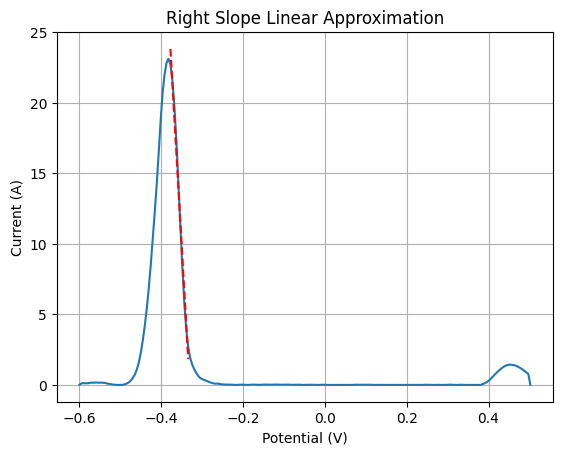

Right slope: -505.55539915297095 µA/V


In [23]:
right_slope = physics.get_right_slope(potential, currents[5], plotting=True)
print(f'Right slope: {right_slope} µA/V')

In [20]:
slope_asymmetry = physics.get_slope_asymmetry(potential, currents[5])
print(f'Slope Asymmetry: {slope_asymmetry}')

mean_slope = physics.get_mean_slope(potential, currents[5])
print(f'Mean slope: {mean_slope} µA/V')

sharpness = physics.get_peak_sharpness(potential, currents[5])
print(f'Peak Sharpness: {sharpness} µA/V²')

SNR = physics.get_SNR(potential, currents[5])
print(f'Signal-to-Noise Ratio: {SNR}')

Slope Asymmetry: 0.7269242569150223
Mean slope: 436.52794100581093 µA/V
Peak Sharpness: -29344.721934010595 µA/V²
Signal-to-Noise Ratio: 64.83457237020059


### Category B: Baseline & Background
The experimental metadata, describing the background in which the signal occurs.
| *  | Feature               | Details |
|--- | --------------------- | ------- |
| 1. | Mean baseline current | The average current in a region outside the peak. |
| 2. | Baseline slope        | A linear trend in the baseline region. |
| 3. | Pre-peak baseline slope | Slope of baseline before the peak starts rising. |
| 4. | Post-peak baseline slope | Slope of baseline after the peak decays. |
| 5. | Baseline RMS noise | The random fluctuation amplitude of the baseline (standard deviation (or RMS) of baseline after mean removal). |
| 6. | Signal-to-noise ratio (SNR) | How distinguishable is the peak from the background. |

In [ ]:
from scipy.stats import linregress
import numpy as np

def get_features_category_b(potential, current):
    # index of max current (peak) 
    # we go relative to this point 
    peak_idx = np.argmax(current)
    # FEEDBACK: this is problematic due to bigger noise in smaller concentrations. A region around the peak would be better

    # defining the three zones based on the peak: baseline, pre-preak and post-peak
    # we consider the first 15 points as baseline 
    baseline_end = 15
    base_slice = slice(0, baseline_end) 

    #extract data
    x_base = potential[base_slice]
    y_base = current[base_slice]

    # 1. Mean Baseline Current: avg of the flat part (before the reaction)
    mean_base = np.mean(y_base)
    # I don't like it. This is encoding information only from the first part of the signal. But the baseline should contain both post and pre-peak info.

    # 2. Baseline slope: slope of the baseline (to see if there is a drift / tilt)
    # using linregress
    if len(x_base) > 1:
        slope, intercept, _, _, _ = linregress(x_base, y_base)
        
        # calc residuals (actual - predicted) to find noise
        y_pred = slope * x_base + intercept
        residuals = y_base - y_pred
        # 5. Baseline RMS noise: identify differences between actual point and the linear regression line
        rms_noise = np.sqrt(np.mean(residuals**2))
    else:
        slope = 0
        rms_noise = 0

    # 3. Pre-peak slope: calc how steep the climb is
    pre_start = max(0, peak_idx - 5)
    if peak_idx > pre_start:
        pre_slope, _, _, _, _ = linregress(potential[pre_start:peak_idx], 
                                           current[pre_start:peak_idx])
    else:
        pre_slope = 0

    # 4. post-peak slope: calc how steep the decline is
    post_end = min(len(current), peak_idx + 5)
    if post_end > peak_idx:
        post_slope, _, _, _, _ = linregress(potential[peak_idx:post_end], 
                                            current[peak_idx:post_end])
    else:
        post_slope = 0
    return {
        "Mean_Baseline": mean_base,
        "Baseline_Slope": slope,
        "Baseline_RMS": rms_noise,
        "Pre_Peak_Slope": pre_slope,
        "Post_Peak_Slope": post_slope
    }

In [22]:
features_list = []
for i, current in enumerate(currents):
    # fix data if necessary
    current = np.array(current, dtype=float)
    potential = np.array(potential, dtype=float)

    # get features
    features = get_features_category_b(potential, current)
    features['Signal_idx'] = i
    features_list.append(features)

df_task_b = pd.DataFrame(features_list)
print(df_task_b.head())
df_task_b.to_excel('features_category_b.xlsx', index=False, sheet_name='category_b_features')

   Mean_Baseline  Baseline_Slope  Baseline_RMS  Pre_Peak_Slope  \
0       0.014617       -0.653677      0.014604        2.904106   
1       0.172864        1.726892      0.053452      232.509016   
2       0.168606        1.106599      0.059024      284.827683   
3       0.152448        0.570968      0.051097      280.032193   
4       0.116645        0.832615      0.034097      340.811600   

   Post_Peak_Slope  Signal_idx  
0        -5.450238           0  
1      -341.298139           1  
2      -221.577604           2  
3      -266.980443           3  
4      -308.299437           4  


### Category C: Shape & Geometry

| *  | Feature               | Details |
|--- | --------------------- | ------- |
| 1. | Skewness              | Peak asymmetry computed through distribution: $$skew = \frac{E((x-\mu)^{3})}{\sigma^{3}}$$|
| 2. | Kurtosis              | Where the peak tends to lean: $$kurt=\frac{E((x-\mu)^4)}{\sigma^{4}}$$ |
| 3. | Rising-time | How quickly the peak climbs. |
| 4. | Falling-time | How quicly the peak decays. |
| 5. | Inflection points | ... |

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis


def get_features_category_c(potential, current):
    # identify peak (relative to this point)
    peak_idx = np.argmax(current)
    peak_height = current[peak_idx]

    # peak region for statistic stats (skewness, kurtosis)
    # only points above 10% of peak height (avoid noise)
    threshold = peak_height * 0.10
    peak_region_mask = current > threshold
    y_peak_region = current[peak_region_mask]

    # 1. Skewness: measure of asymmetry (leaning left or right)
    if len(y_peak_region) > 3:
        feat_skew = skew(y_peak_region)
    else:
        feat_skew = 0

    # 2. Kurtosis: measure of sharpness (pointy or flat)
    if len(y_peak_region) > 3:
        feat_kurt = kurtosis(y_peak_region)
    else:
        feat_kurt = 0

    # thresholds for rise/fall time calculations (10% and 90%)
    low_thresh = 0.10 * peak_height
    high_thresh = 0.90 * peak_height

    # 3. Rise Time: calc time (potential) to go from 10% to 90% up the peak
    # slice array up to the peak
    rise_side_current = current[:peak_idx]
    rise_side_potential = potential[:peak_idx]

    if len(rise_side_current) > 0:
        # find indices closest to 10% and 90%
        idx_10 = (np.abs(rise_side_current - low_thresh)).argmin()
        idx_90 = (np.abs(rise_side_current - high_thresh)).argmin()
        
        # calc potential difference
        rise_time = abs(rise_side_potential[idx_90] - rise_side_potential[idx_10])
    else:
        rise_time = 0

    # 4. Fall Time: calc time (potential) to drop from 90% to 10% down the peak
    # slice array after the peak
    fall_side_current = current[peak_idx:]
    fall_side_potential = potential[peak_idx:]

    if len(fall_side_current) > 0:
        idx_90_fall = (np.abs(fall_side_current - high_thresh)).argmin()
        idx_10_fall = (np.abs(fall_side_current - low_thresh)).argmin()
        
        fall_time = abs(fall_side_potential[idx_10_fall] - fall_side_potential[idx_90_fall])
    else:
        fall_time = 0

    # 5. Inflection Points: points where curvature changes (convex/concave)
    # calc 1st and 2nd derivatives
    d1 = np.gradient(current)
    d2 = np.gradient(d1)
    
    # count how many times 2nd derivative changes sign
    sign_changes = np.diff(np.sign(d2))
    # we filter for changes inside our defined peak region
    inflections = np.sum(np.abs(sign_changes[peak_region_mask[:-1]]) > 0)

    return {
        "Skewness": feat_skew,
        "Kurtosis": feat_kurt,
        "Rise_Time": rise_time,
        "Fall_Time": fall_time,
        "Inflection_Points": inflections
    }

In [ ]:
# process for category C
task_c_results = []
for i, current in enumerate(currents):
    # fix data if necessary
    current = np.array(current, dtype=float)
    potential = np.array(potential, dtype=float)

    feats = get_features_category_c(potential, current)
    feats['Signal_Index'] = i
    task_c_results.append(feats)

df_task_c = pd.DataFrame(task_c_results)
print(df_task_c.head())
df_task_c.to_excel('features_category_c.xlsx', index=False, sheet_name='category_c_features')

### Category D: : Statistical Descriptors

In [ ]:
from scipy.stats import entropy
import numpy as np
import pandas as pd

def get_features_category_d(potential, current):
    # potential kept for consistency, not used in calculations
    # A. Full Signal
    region_full = current
    
    # B. Baseline Window
    # consistent with category B, first 15 points
    baseline_end = 15
    region_base = current[:baseline_end]
    
    # C. Peak Window
    # consistent with category C, points > 10% of peak height
    peak_val = np.max(current)
    threshold = 0.10 * peak_val
    region_peak = current[current > threshold]
    
    # Helper function to calculate stats for any given region data
    def calculate_stats(data, region_name):
        if len(data) == 0:
            return {}
            
        # 1. Basic Stats: mean, std, variance
        val_mean = np.mean(data)
        val_std = np.std(data)
        val_var = np.var(data)
        
        # 2. Max / Min ratio
        # we add a small epsilon (1e-9) to avoid dividing by zero if min is 0
        val_min = np.min(data)
        val_max = np.max(data)
        val_max_min_ratio = val_max / (val_min + 1e-9)
        
        # 3. Percentiles (25%, 50%, 75%)
        # 50% is the median
        p25 = np.percentile(data, 25)
        p50 = np.percentile(data, 50)
        p75 = np.percentile(data, 75)
        
        # 4. Entropy
        # measures the "randomness" of data distribution
        # we normalize data to sum to 1 to treat it like a probability distribution
        # using abs() to handle if there is negative noise
        data_norm = np.abs(data) / (np.sum(np.abs(data)) + 1e-9)
        val_entropy = entropy(data_norm)
        
        return {
            f"{region_name}_mean": val_mean,
            f"{region_name}_std": val_std,
            f"{region_name}_var": val_var,
            f"{region_name}_max_min": val_max_min_ratio,
            f"{region_name}_p25": p25,
            f"{region_name}_p50": p50,
            f"{region_name}_p75": p75,
            f"{region_name}_entropy": val_entropy
        }

    features = {}
    
    # merge dictionaries from all 3 regions
    features.update(calculate_stats(region_full, "Full"))
    features.update(calculate_stats(region_peak, "Peak"))
    features.update(calculate_stats(region_base, "Base"))
    
    return features

In [ ]:
task_d_results = []
for i, current in enumerate(currents):
    # fix data if necessary
    current = np.array(current, dtype=float)
    potential = np.array(potential, dtype=float)

    feats = get_features_category_d(potential, current)
    feats['Signal_Index'] = i
    task_d_results.append(feats)

df_task_d = pd.DataFrame(task_d_results)
print(df_task_d.head())
df_task_d.to_excel('features_category_d.xlsx', index=False, sheet_name='category_d_features')